
We will implement a [Denoising Diffusion Probabilistic Model](https://arxiv.org/pdf/2006.11239.pdf). 

In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from unet import Unet
import os
import math
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [3]:
def create_mnist_dataloaders(batch_size,image_size=28,num_workers=2):
    '''
        Data loading code. Do not modify.
    '''

    preprocess=transforms.Compose([transforms.Resize(image_size),\
                                    transforms.ToTensor(),\
                                    transforms.Normalize([0.5],[0.5])]) #[0,1] to [-1,1]

    train_dataset=MNIST(root="./mnist_data",\
                        train=True,\
                        download=True,\
                        transform=preprocess
                        )

    # Pick out only the first 5000 1s
    valid_idxs = []
    for idx, d in enumerate(train_dataset):
        if(d[1] in [1,2]):
            valid_idxs.append(idx)
        if(len(valid_idxs) >= 5000):
            break

    # Create subset
    train_dataset = torch.utils.data.Subset(train_dataset, valid_idxs)

    return DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

## Model Implementation

In this section you will implement each part of the diffusion model. That is the model parameters, forward diffusion, reverse diffusion, and the denoising sampling procedure.

In [4]:
import torch.nn as nn
import torch
import math
from unet import Unet
from tqdm import tqdm

class MNISTDiffusion(nn.Module):
    def __init__(self,image_size,in_channels,time_embedding_dim=256,timesteps=1000,base_dim=32,dim_mults= [1, 2, 4, 8]):
        super().__init__()

        ###
        #  Part a: Your code here
        ###
        self.timesteps = timesteps
        self.in_channels = in_channels
        self.image_size = image_size

        betas = self._cosine_variance_schedule(timesteps)
        alphas = 1. - betas
        alphas_c = torch.cumprod(alphas, dim=-1)

        self.betas = nn.Parameter(betas, requires_grad=False)
        self.alphas = nn.Parameter(alphas, requires_grad=False)
        self.alphas_c = nn.Parameter(alphas_c, requires_grad=False)
        self.sqrt_alphas_c = nn.Parameter(torch.sqrt(alphas_c), requires_grad=False)
        self.sqrt_one_minus_alphas_c = nn.Parameter(torch.sqrt(1. - alphas_c), requires_grad=False)


        self.model=Unet(timesteps,time_embedding_dim,in_channels,in_channels,base_dim,dim_mults)


    def _cosine_variance_schedule(self,timesteps,epsilon= 0.008):
        steps=torch.linspace(0,timesteps,steps=timesteps+1,dtype=torch.float32)
        f_t=torch.cos(((steps/timesteps+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
        betas=torch.clip(1.0-f_t[1:]/f_t[:timesteps],0.0,0.999)

        return betas


    def forward(self,x,noise):
        # x:NCHW
        # Generate a target time, run forward diffusion, and predict

        t=torch.randint(0,self.timesteps,(x.shape[0],)).to(x.device)
        xx=self._forward_diffusion(x,t,noise)
        pred_noise=self.model(xx,t)

        return pred_noise


    def _forward_diffusion(self,x_0,t,noise):

        # Apply forward diffusion
        assert x_0.shape==noise.shape
        contribution_alphas = self.sqrt_alphas_c.gather(-1, t).reshape(x_0.shape[0], 1, 1, 1) * x_0
        contribution_one_minus_alphas = self.sqrt_one_minus_alphas_c.gather(-1, t).reshape(x_0.shape[0], 1, 1, 1) * noise
        noisy_sample = contribution_alphas + contribution_one_minus_alphas

        return noisy_sample


    @torch.no_grad()
    def _reverse_diffusion(self,x_t,t,noise):
        '''
        p(x_{t-1}|x_{t})-> mean,std

        pred_noise-> pred_mean and pred_std
        '''

        # Predict noise for the current state x_t using the model
        pred = self.model(x_t, t)

        # Gather alpha, beta, and cumulative alpha values for time step t
        alpha_t = self.alphas.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        alpha_t_c = self.alphas_c.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        beta_t = self.betas.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        sqrt_one_minus_alpha_c_t = self.sqrt_one_minus_alphas_c.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)

        # Calculate the mean for the previous state x_{t-1}
        mean = (1. / torch.sqrt(alpha_t)) * (x_t - ((1.0 - alpha_t) / sqrt_one_minus_alpha_c_t) * pred)

        # Calculate the standard deviation for the previous state x_{t-1}
        if t.min() > 0:
            alpha_t_c_prev = self.alphas_c.gather(-1, t - 1).reshape(x_t.shape[0], 1, 1, 1)
            std = torch.sqrt(beta_t * (1. - alpha_t_c_prev) / (1. - alpha_t_c))
        else:
            std = torch.zeros_like(mean)


        return mean+std*noise


    @torch.no_grad()
    def sampling(self, n_samples, device="cuda"):

        # Initialize list to store all generated samples
        all_samples = []

        # Initialize input with random noise
        sample = torch.randn((n_samples, self.in_channels, self.image_size, self.image_size)).to(device)

        # Iterate over diffusion time steps in reverse order
        for i in tqdm(range(self.timesteps - 1, -1, -1), desc="Sampling"):
            # Generate noise for the current time step
            noise = torch.randn_like(sample).to(device)

            # Create diffusion time step tensor
            t = torch.full((n_samples,), i, dtype=torch.long).to(device)

            # Perform reverse diffusion
            sample = self._reverse_diffusion(sample, t, noise)

            # Clamp the values of sample to lie between -1 and 1
            sample = torch.clamp(sample, min=-1, max=1)

            # Append generated sample to the list
            all_samples.append(sample.clone())

        # Convert list of all samples to a tensor
        all_samples = torch.stack(all_samples)



        return sample.clone(), all_samples.clone()

## Model Training

You will need to choose a learning rate, batch size, number of epochs, model dimension, and number of timesteps. You will also need to select an optimizer, scheduler, and loss function.

In [5]:
def main():
    device = "cuda" if torch.cuda.is_available() else 'cpu'

    # Model and training hyperparameters
    lr = 0.0005
    batch_size = 28
    epochs = 120
    model_base_dim = 32

    # Number of noising/denoising steps to take
    timesteps = 10000

    # Controls how often loss is printed and plots are generated
    log_freq = 10
    plot_freq = 10

    # For plotting. Do not modify.
    n_samples = 36

    # Get data
    train_dataloader=create_mnist_dataloaders(batch_size=batch_size,image_size=28)

    # Get model
    model=MNISTDiffusion(timesteps=timesteps,
                image_size=28,
                in_channels=1,
                base_dim=model_base_dim,
                dim_mults=[2,4]).to(device)


    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader),pct_start=0.25,anneal_strategy='cos')
    loss_fn = nn.MSELoss(reduction='mean')

    global_steps=0
    for i in range(epochs):
        model.train()
        for j,(image,target) in enumerate(train_dataloader):
          noise=torch.randn_like(image).to(device)
          image=image.to(device)
          pred=model(image,noise)
          loss=loss_fn(pred,noise)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          scheduler.step()
            # Implement your forward pass and backpropagation
            # Print training progress
          global_steps+=1
          if j%log_freq==0:
            print("Epoch[{}/{}],Step[{}/{}],loss:{:.5f},lr:{:.5f}".format(i+1,epochs,j,len(train_dataloader),
                                                                          loss.detach().cpu().item(),scheduler.get_last_lr()[0]))
        if(i%plot_freq == 0):
            ckpt={"model":model.state_dict()}
            os.makedirs("results",exist_ok=True)
            torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))
            model.eval()
            s, samples = model.sampling(n_samples,device=device)
            save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    # Final round of plots
    os.makedirs("results",exist_ok=True)
    torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))

    model.eval()
    s, samples=model.sampling(n_samples,device=device)
    save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    return samples

In [6]:
samples = main()

100%|██████████| 9912422/9912422 [00:00<00:00, 412613001.37it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 36192319.64it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 112824095.35it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 20309732.16it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Epoch[1/120],Step[0/179],loss:1.10776,lr:0.00002
Epoch[1/120],Step[10/179],loss:1.07304,lr:0.00002
Epoch[1/120],Step[20/179],loss:1.10488,lr:0.00002
Epoch[1/120],Step[30/179],loss:1.08373,lr:0.00002
Epoch[1/120],Step[40/179],loss:1.06697,lr:0.00002
Epoch[1/120],Step[50/179],loss:1.08946,lr:0.00002
Epoch[1/120],Step[60/179],loss:1.06333,lr:0.00002
Epoch[1/120],Step[70/179],loss:1.08080,lr:0.00002
Epoch[1/120],Step[80/179],loss:1.06410,lr:0.00002
Epoch[1/120],Step[90/179],loss:1.06727,lr:0.00002
Epoch[1/120],Step[100/179],loss:1.05810,lr:0.00002
Epoch[1/120],Step[110/179],loss:1.04272,lr:0.00002
Epoch[1/120],Step[120/179],loss:1.06908,lr:0.00002
Epoch[1/120],Step[130/179],loss:1.08842,lr:0.00002
Epoch[1/120],Step[140/179],loss:1.06018,lr:0.00002
Epoch[1/120],Step[150/179],loss:1.04725,lr:0.00002
Epoch[1/120],Step[160/179],loss:1.04522,lr:0.00002
Epoch[1/120],Step[170/179],loss:1.04707,lr:0.00002


Sampling: 100%|██████████| 10000/10000 [03:26<00:00, 48.51it/s]


Epoch[2/120],Step[0/179],loss:1.03414,lr:0.00002
Epoch[2/120],Step[10/179],loss:1.02429,lr:0.00002
Epoch[2/120],Step[20/179],loss:1.03060,lr:0.00002
Epoch[2/120],Step[30/179],loss:1.01068,lr:0.00002
Epoch[2/120],Step[40/179],loss:1.03417,lr:0.00002
Epoch[2/120],Step[50/179],loss:1.01360,lr:0.00002
Epoch[2/120],Step[60/179],loss:0.99715,lr:0.00002
Epoch[2/120],Step[70/179],loss:1.00357,lr:0.00002
Epoch[2/120],Step[80/179],loss:1.01610,lr:0.00002
Epoch[2/120],Step[90/179],loss:1.00643,lr:0.00002
Epoch[2/120],Step[100/179],loss:1.01114,lr:0.00002
Epoch[2/120],Step[110/179],loss:0.99635,lr:0.00002
Epoch[2/120],Step[120/179],loss:1.00333,lr:0.00002
Epoch[2/120],Step[130/179],loss:0.97378,lr:0.00002
Epoch[2/120],Step[140/179],loss:0.99501,lr:0.00002
Epoch[2/120],Step[150/179],loss:0.99169,lr:0.00002
Epoch[2/120],Step[160/179],loss:0.97486,lr:0.00002
Epoch[2/120],Step[170/179],loss:0.99308,lr:0.00003
Epoch[3/120],Step[0/179],loss:0.97712,lr:0.00003
Epoch[3/120],Step[10/179],loss:0.97210,lr:0.

Sampling: 100%|██████████| 10000/10000 [03:32<00:00, 47.11it/s]


Epoch[12/120],Step[0/179],loss:0.29182,lr:0.00016
Epoch[12/120],Step[10/179],loss:0.30701,lr:0.00016
Epoch[12/120],Step[20/179],loss:0.25358,lr:0.00017
Epoch[12/120],Step[30/179],loss:0.30253,lr:0.00017
Epoch[12/120],Step[40/179],loss:0.32913,lr:0.00017
Epoch[12/120],Step[50/179],loss:0.28038,lr:0.00017
Epoch[12/120],Step[60/179],loss:0.27439,lr:0.00017
Epoch[12/120],Step[70/179],loss:0.24678,lr:0.00017
Epoch[12/120],Step[80/179],loss:0.30374,lr:0.00017
Epoch[12/120],Step[90/179],loss:0.23651,lr:0.00017
Epoch[12/120],Step[100/179],loss:0.33280,lr:0.00018
Epoch[12/120],Step[110/179],loss:0.24709,lr:0.00018
Epoch[12/120],Step[120/179],loss:0.25418,lr:0.00018
Epoch[12/120],Step[130/179],loss:0.27414,lr:0.00018
Epoch[12/120],Step[140/179],loss:0.24677,lr:0.00018
Epoch[12/120],Step[150/179],loss:0.23890,lr:0.00018
Epoch[12/120],Step[160/179],loss:0.24924,lr:0.00018
Epoch[12/120],Step[170/179],loss:0.23771,lr:0.00018
Epoch[13/120],Step[0/179],loss:0.23954,lr:0.00019
Epoch[13/120],Step[10/179

Sampling: 100%|██████████| 10000/10000 [03:33<00:00, 46.95it/s]


Epoch[22/120],Step[0/179],loss:0.07912,lr:0.00040
Epoch[22/120],Step[10/179],loss:0.15454,lr:0.00040
Epoch[22/120],Step[20/179],loss:0.08210,lr:0.00040
Epoch[22/120],Step[30/179],loss:0.08147,lr:0.00040
Epoch[22/120],Step[40/179],loss:0.09642,lr:0.00041
Epoch[22/120],Step[50/179],loss:0.09402,lr:0.00041
Epoch[22/120],Step[60/179],loss:0.11951,lr:0.00041
Epoch[22/120],Step[70/179],loss:0.08931,lr:0.00041
Epoch[22/120],Step[80/179],loss:0.11324,lr:0.00041
Epoch[22/120],Step[90/179],loss:0.08357,lr:0.00041
Epoch[22/120],Step[100/179],loss:0.08966,lr:0.00041
Epoch[22/120],Step[110/179],loss:0.11427,lr:0.00041
Epoch[22/120],Step[120/179],loss:0.08582,lr:0.00041
Epoch[22/120],Step[130/179],loss:0.10548,lr:0.00042
Epoch[22/120],Step[140/179],loss:0.08589,lr:0.00042
Epoch[22/120],Step[150/179],loss:0.11105,lr:0.00042
Epoch[22/120],Step[160/179],loss:0.09342,lr:0.00042
Epoch[22/120],Step[170/179],loss:0.07617,lr:0.00042
Epoch[23/120],Step[0/179],loss:0.08419,lr:0.00042
Epoch[23/120],Step[10/179

Sampling: 100%|██████████| 10000/10000 [03:32<00:00, 47.05it/s]


Epoch[32/120],Step[0/179],loss:0.07295,lr:0.00050
Epoch[32/120],Step[10/179],loss:0.06428,lr:0.00050
Epoch[32/120],Step[20/179],loss:0.05306,lr:0.00050
Epoch[32/120],Step[30/179],loss:0.08041,lr:0.00050
Epoch[32/120],Step[40/179],loss:0.06235,lr:0.00050
Epoch[32/120],Step[50/179],loss:0.08068,lr:0.00050
Epoch[32/120],Step[60/179],loss:0.06583,lr:0.00050
Epoch[32/120],Step[70/179],loss:0.06563,lr:0.00050
Epoch[32/120],Step[80/179],loss:0.07179,lr:0.00050
Epoch[32/120],Step[90/179],loss:0.06772,lr:0.00050
Epoch[32/120],Step[100/179],loss:0.06724,lr:0.00050
Epoch[32/120],Step[110/179],loss:0.07652,lr:0.00050
Epoch[32/120],Step[120/179],loss:0.07676,lr:0.00050
Epoch[32/120],Step[130/179],loss:0.05865,lr:0.00050
Epoch[32/120],Step[140/179],loss:0.10153,lr:0.00050
Epoch[32/120],Step[150/179],loss:0.07343,lr:0.00050
Epoch[32/120],Step[160/179],loss:0.08777,lr:0.00050
Epoch[32/120],Step[170/179],loss:0.06348,lr:0.00050
Epoch[33/120],Step[0/179],loss:0.05143,lr:0.00050
Epoch[33/120],Step[10/179

Sampling: 100%|██████████| 10000/10000 [03:32<00:00, 47.16it/s]


Epoch[42/120],Step[0/179],loss:0.06288,lr:0.00048
Epoch[42/120],Step[10/179],loss:0.07466,lr:0.00048
Epoch[42/120],Step[20/179],loss:0.05053,lr:0.00048
Epoch[42/120],Step[30/179],loss:0.06346,lr:0.00048
Epoch[42/120],Step[40/179],loss:0.05236,lr:0.00048
Epoch[42/120],Step[50/179],loss:0.04989,lr:0.00048
Epoch[42/120],Step[60/179],loss:0.04486,lr:0.00048
Epoch[42/120],Step[70/179],loss:0.05763,lr:0.00048
Epoch[42/120],Step[80/179],loss:0.07060,lr:0.00048
Epoch[42/120],Step[90/179],loss:0.04912,lr:0.00048
Epoch[42/120],Step[100/179],loss:0.05371,lr:0.00048
Epoch[42/120],Step[110/179],loss:0.05283,lr:0.00048
Epoch[42/120],Step[120/179],loss:0.04481,lr:0.00048
Epoch[42/120],Step[130/179],loss:0.05028,lr:0.00048
Epoch[42/120],Step[140/179],loss:0.07109,lr:0.00048
Epoch[42/120],Step[150/179],loss:0.04902,lr:0.00048
Epoch[42/120],Step[160/179],loss:0.06739,lr:0.00048
Epoch[42/120],Step[170/179],loss:0.06744,lr:0.00048
Epoch[43/120],Step[0/179],loss:0.05171,lr:0.00048
Epoch[43/120],Step[10/179

Sampling: 100%|██████████| 10000/10000 [03:29<00:00, 47.67it/s]


Epoch[52/120],Step[0/179],loss:0.05010,lr:0.00044
Epoch[52/120],Step[10/179],loss:0.04533,lr:0.00044
Epoch[52/120],Step[20/179],loss:0.05444,lr:0.00044
Epoch[52/120],Step[30/179],loss:0.04112,lr:0.00043
Epoch[52/120],Step[40/179],loss:0.04441,lr:0.00043
Epoch[52/120],Step[50/179],loss:0.06077,lr:0.00043
Epoch[52/120],Step[60/179],loss:0.04195,lr:0.00043
Epoch[52/120],Step[70/179],loss:0.05902,lr:0.00043
Epoch[52/120],Step[80/179],loss:0.04513,lr:0.00043
Epoch[52/120],Step[90/179],loss:0.03764,lr:0.00043
Epoch[52/120],Step[100/179],loss:0.04713,lr:0.00043
Epoch[52/120],Step[110/179],loss:0.04808,lr:0.00043
Epoch[52/120],Step[120/179],loss:0.04956,lr:0.00043
Epoch[52/120],Step[130/179],loss:0.06476,lr:0.00043
Epoch[52/120],Step[140/179],loss:0.05664,lr:0.00043
Epoch[52/120],Step[150/179],loss:0.04108,lr:0.00043
Epoch[52/120],Step[160/179],loss:0.04520,lr:0.00043
Epoch[52/120],Step[170/179],loss:0.06700,lr:0.00043
Epoch[53/120],Step[0/179],loss:0.06558,lr:0.00043
Epoch[53/120],Step[10/179

Sampling: 100%|██████████| 10000/10000 [03:27<00:00, 48.20it/s]


Epoch[62/120],Step[0/179],loss:0.04081,lr:0.00037
Epoch[62/120],Step[10/179],loss:0.05142,lr:0.00037
Epoch[62/120],Step[20/179],loss:0.03643,lr:0.00037
Epoch[62/120],Step[30/179],loss:0.04676,lr:0.00037
Epoch[62/120],Step[40/179],loss:0.04074,lr:0.00037
Epoch[62/120],Step[50/179],loss:0.04271,lr:0.00037
Epoch[62/120],Step[60/179],loss:0.04887,lr:0.00036
Epoch[62/120],Step[70/179],loss:0.04536,lr:0.00036
Epoch[62/120],Step[80/179],loss:0.03466,lr:0.00036
Epoch[62/120],Step[90/179],loss:0.04328,lr:0.00036
Epoch[62/120],Step[100/179],loss:0.04377,lr:0.00036
Epoch[62/120],Step[110/179],loss:0.06465,lr:0.00036
Epoch[62/120],Step[120/179],loss:0.04880,lr:0.00036
Epoch[62/120],Step[130/179],loss:0.07151,lr:0.00036
Epoch[62/120],Step[140/179],loss:0.05092,lr:0.00036
Epoch[62/120],Step[150/179],loss:0.03220,lr:0.00036
Epoch[62/120],Step[160/179],loss:0.04412,lr:0.00036
Epoch[62/120],Step[170/179],loss:0.03676,lr:0.00036
Epoch[63/120],Step[0/179],loss:0.03574,lr:0.00036
Epoch[63/120],Step[10/179

Sampling: 100%|██████████| 10000/10000 [03:26<00:00, 48.48it/s]


Epoch[72/120],Step[0/179],loss:0.04368,lr:0.00028
Epoch[72/120],Step[10/179],loss:0.04002,lr:0.00028
Epoch[72/120],Step[20/179],loss:0.03526,lr:0.00028
Epoch[72/120],Step[30/179],loss:0.03538,lr:0.00028
Epoch[72/120],Step[40/179],loss:0.03479,lr:0.00028
Epoch[72/120],Step[50/179],loss:0.03497,lr:0.00028
Epoch[72/120],Step[60/179],loss:0.04245,lr:0.00028
Epoch[72/120],Step[70/179],loss:0.06733,lr:0.00028
Epoch[72/120],Step[80/179],loss:0.05737,lr:0.00028
Epoch[72/120],Step[90/179],loss:0.04720,lr:0.00028
Epoch[72/120],Step[100/179],loss:0.04085,lr:0.00028
Epoch[72/120],Step[110/179],loss:0.03590,lr:0.00028
Epoch[72/120],Step[120/179],loss:0.03254,lr:0.00028
Epoch[72/120],Step[130/179],loss:0.04363,lr:0.00028
Epoch[72/120],Step[140/179],loss:0.03799,lr:0.00028
Epoch[72/120],Step[150/179],loss:0.03516,lr:0.00028
Epoch[72/120],Step[160/179],loss:0.04096,lr:0.00028
Epoch[72/120],Step[170/179],loss:0.03709,lr:0.00028
Epoch[73/120],Step[0/179],loss:0.04259,lr:0.00028
Epoch[73/120],Step[10/179

Sampling: 100%|██████████| 10000/10000 [03:27<00:00, 48.25it/s]


Epoch[82/120],Step[0/179],loss:0.03528,lr:0.00020
Epoch[82/120],Step[10/179],loss:0.03856,lr:0.00020
Epoch[82/120],Step[20/179],loss:0.04048,lr:0.00020
Epoch[82/120],Step[30/179],loss:0.04472,lr:0.00020
Epoch[82/120],Step[40/179],loss:0.03424,lr:0.00020
Epoch[82/120],Step[50/179],loss:0.02791,lr:0.00020
Epoch[82/120],Step[60/179],loss:0.04905,lr:0.00020
Epoch[82/120],Step[70/179],loss:0.04984,lr:0.00019
Epoch[82/120],Step[80/179],loss:0.04726,lr:0.00019
Epoch[82/120],Step[90/179],loss:0.03394,lr:0.00019
Epoch[82/120],Step[100/179],loss:0.04846,lr:0.00019
Epoch[82/120],Step[110/179],loss:0.04439,lr:0.00019
Epoch[82/120],Step[120/179],loss:0.03744,lr:0.00019
Epoch[82/120],Step[130/179],loss:0.04060,lr:0.00019
Epoch[82/120],Step[140/179],loss:0.03674,lr:0.00019
Epoch[82/120],Step[150/179],loss:0.03333,lr:0.00019
Epoch[82/120],Step[160/179],loss:0.04278,lr:0.00019
Epoch[82/120],Step[170/179],loss:0.05580,lr:0.00019
Epoch[83/120],Step[0/179],loss:0.04117,lr:0.00019
Epoch[83/120],Step[10/179

Sampling: 100%|██████████| 10000/10000 [03:26<00:00, 48.41it/s]


Epoch[92/120],Step[0/179],loss:0.03834,lr:0.00012
Epoch[92/120],Step[10/179],loss:0.04431,lr:0.00012
Epoch[92/120],Step[20/179],loss:0.04639,lr:0.00012
Epoch[92/120],Step[30/179],loss:0.04407,lr:0.00012
Epoch[92/120],Step[40/179],loss:0.03400,lr:0.00012
Epoch[92/120],Step[50/179],loss:0.05146,lr:0.00012
Epoch[92/120],Step[60/179],loss:0.05719,lr:0.00011
Epoch[92/120],Step[70/179],loss:0.05313,lr:0.00011
Epoch[92/120],Step[80/179],loss:0.03447,lr:0.00011
Epoch[92/120],Step[90/179],loss:0.03807,lr:0.00011
Epoch[92/120],Step[100/179],loss:0.03886,lr:0.00011
Epoch[92/120],Step[110/179],loss:0.05266,lr:0.00011
Epoch[92/120],Step[120/179],loss:0.03865,lr:0.00011
Epoch[92/120],Step[130/179],loss:0.02732,lr:0.00011
Epoch[92/120],Step[140/179],loss:0.03211,lr:0.00011
Epoch[92/120],Step[150/179],loss:0.03176,lr:0.00011
Epoch[92/120],Step[160/179],loss:0.03296,lr:0.00011
Epoch[92/120],Step[170/179],loss:0.03873,lr:0.00011
Epoch[93/120],Step[0/179],loss:0.03176,lr:0.00011
Epoch[93/120],Step[10/179

Sampling: 100%|██████████| 10000/10000 [03:26<00:00, 48.47it/s]


Epoch[102/120],Step[0/179],loss:0.04596,lr:0.00005
Epoch[102/120],Step[10/179],loss:0.03019,lr:0.00005
Epoch[102/120],Step[20/179],loss:0.03604,lr:0.00005
Epoch[102/120],Step[30/179],loss:0.03254,lr:0.00005
Epoch[102/120],Step[40/179],loss:0.04317,lr:0.00005
Epoch[102/120],Step[50/179],loss:0.04030,lr:0.00005
Epoch[102/120],Step[60/179],loss:0.04372,lr:0.00005
Epoch[102/120],Step[70/179],loss:0.04219,lr:0.00005
Epoch[102/120],Step[80/179],loss:0.03525,lr:0.00005
Epoch[102/120],Step[90/179],loss:0.04039,lr:0.00005
Epoch[102/120],Step[100/179],loss:0.02860,lr:0.00005
Epoch[102/120],Step[110/179],loss:0.04544,lr:0.00005
Epoch[102/120],Step[120/179],loss:0.04416,lr:0.00005
Epoch[102/120],Step[130/179],loss:0.03551,lr:0.00005
Epoch[102/120],Step[140/179],loss:0.04560,lr:0.00005
Epoch[102/120],Step[150/179],loss:0.03035,lr:0.00005
Epoch[102/120],Step[160/179],loss:0.04376,lr:0.00005
Epoch[102/120],Step[170/179],loss:0.03286,lr:0.00005
Epoch[103/120],Step[0/179],loss:0.03663,lr:0.00005
Epoch[

Sampling: 100%|██████████| 10000/10000 [03:22<00:00, 49.36it/s]


Epoch[112/120],Step[0/179],loss:0.03682,lr:0.00001
Epoch[112/120],Step[10/179],loss:0.03218,lr:0.00001
Epoch[112/120],Step[20/179],loss:0.03536,lr:0.00001
Epoch[112/120],Step[30/179],loss:0.04921,lr:0.00001
Epoch[112/120],Step[40/179],loss:0.03382,lr:0.00001
Epoch[112/120],Step[50/179],loss:0.03552,lr:0.00001
Epoch[112/120],Step[60/179],loss:0.02872,lr:0.00001
Epoch[112/120],Step[70/179],loss:0.03261,lr:0.00001
Epoch[112/120],Step[80/179],loss:0.04324,lr:0.00001
Epoch[112/120],Step[90/179],loss:0.05580,lr:0.00001
Epoch[112/120],Step[100/179],loss:0.04883,lr:0.00001
Epoch[112/120],Step[110/179],loss:0.02937,lr:0.00001
Epoch[112/120],Step[120/179],loss:0.03724,lr:0.00001
Epoch[112/120],Step[130/179],loss:0.03429,lr:0.00001
Epoch[112/120],Step[140/179],loss:0.02770,lr:0.00001
Epoch[112/120],Step[150/179],loss:0.03742,lr:0.00001
Epoch[112/120],Step[160/179],loss:0.04277,lr:0.00001
Epoch[112/120],Step[170/179],loss:0.06414,lr:0.00001
Epoch[113/120],Step[0/179],loss:0.04519,lr:0.00001
Epoch[

Sampling: 100%|██████████| 10000/10000 [03:24<00:00, 48.94it/s]


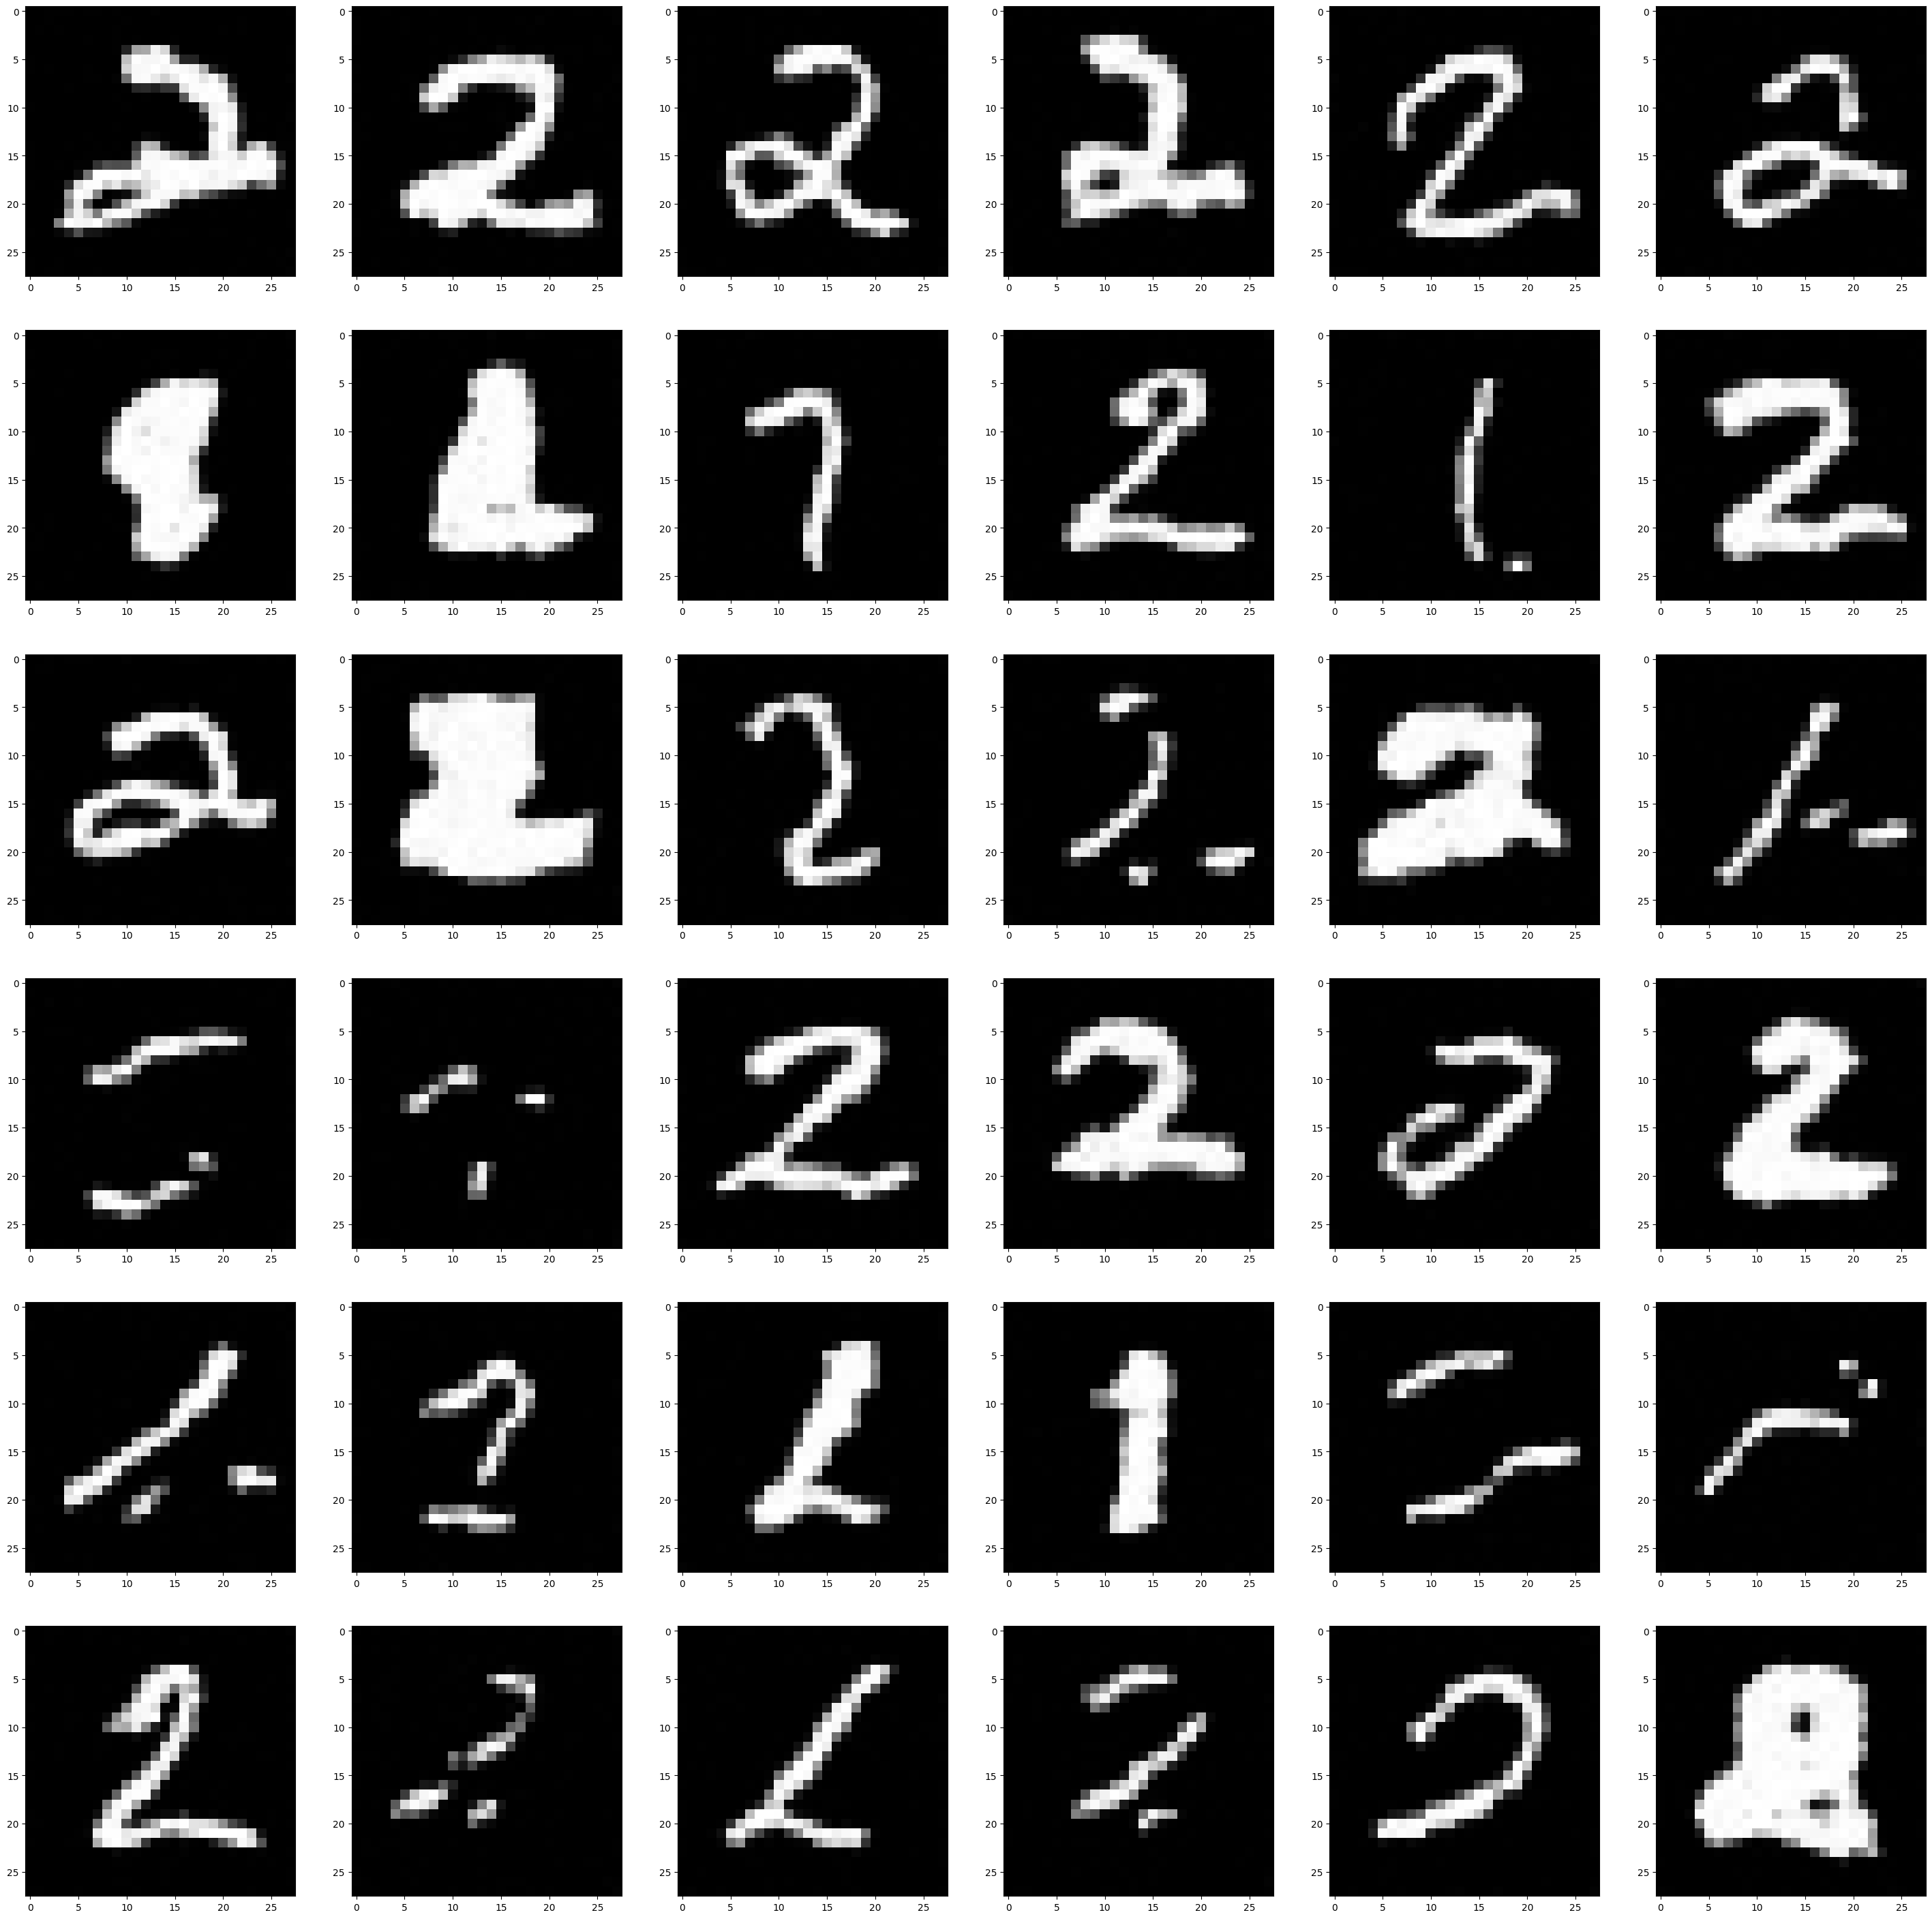

In [10]:
import matplotlib.pyplot as plt
import torch

# Assuming samples is a list of tensors
# Move tensors from CPU to GPU if not already there
samples_gpu = [sample.cuda() if not sample.is_cuda else sample for sample in samples]

# Plotting code
fig, ax = plt.subplots(ncols=6, nrows=6, figsize=(36,36))
for i in range(36):
    # Convert CUDA tensor to numpy array on GPU
    image_np = samples_gpu[-1][i][0].cpu().numpy()
    ax[i//6][i%6].imshow(image_np, cmap='gray',  interpolation='nearest')
plt.savefig("./learned_diffusion_ones.pdf")
plt.show()


## f) Diffusion Visualization
Here you will need to implement a plotting function that visualizes noise turning into a clean sample. Do not forget to label each image with its corresponding denoising step.

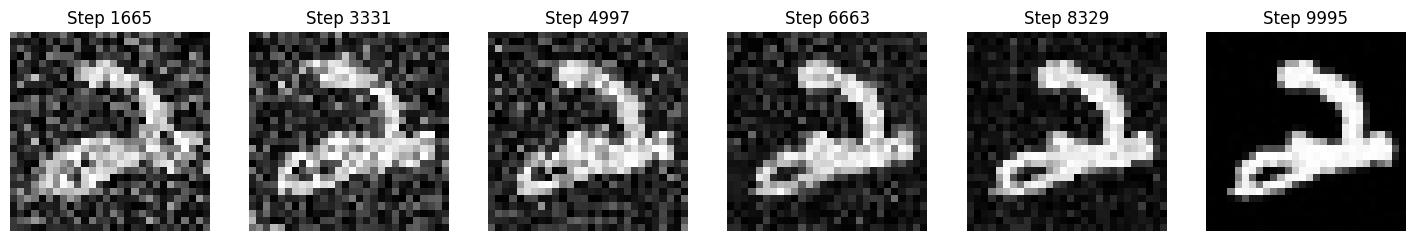

In [33]:
import matplotlib.pyplot as plt
import torch

# Assuming samples is a list of tensors
# Move tensors from CPU to GPU if not already there
samples_gpu = [sample.cuda() if not sample.is_cuda else sample for sample in samples]

# Choose a single sample point for visualization
sample_index = 0  # Choose the index of the sample you want to visualize

# Plotting code for the denoising process of the selected sample
fig, ax = plt.subplots(ncols=6, figsize=(18, 3))  # Adjust figsize as needed

# Calculate the number of denoising steps
num_steps = len(samples_gpu)

# Calculate the step size for 6 intervals
step_size = num_steps // 6

for i in range(6):
    # Calculate the index of the denoising step for the current interval
    step_num = min((i + 1) * step_size, num_steps) - 1  # Ensure not to exceed num_steps and subtract 1 to start from 0
    # Plot the image at the corresponding denoising step
    ax[i].imshow(samples_gpu[step_num][sample_index][0].cpu().numpy(), cmap='gray', interpolation='nearest')
    ax[i].set_title(f'Step {step_num}')
    ax[i].axis('off')

plt.savefig("./denoising_process.png")
plt.show()
